In [2]:
!pip install thop ptflops


Loading UMAFall Dataset (Segmentation Mode)
/content/drive/MyDrive/HAR_Dataset/UMAFALL/UMAFall_Subject_18_ADL_Sitting_GettingUpOnAChair_2_2016-05-29_20-48-00.csv
/content/drive/MyDrive/HAR_Dataset/UMAFALL/UMAFall_Subject_04_Fall_backwardFall_2_2016-06-13_13-19-53.csv
/content/drive/MyDrive/HAR_Dataset/UMAFALL/UMAFall_Subject_02_Fall_lateralFall_2_2016-06-13_20-50-00.csv
/content/drive/MyDrive/HAR_Dataset/UMAFALL/UMAFall_Subject_03_ADL_Walking_3_2017-04-14_23-45-34.csv
/content/drive/MyDrive/HAR_Dataset/UMAFALL/UMAFall_Subject_19_Fall_lateralFall_3_2016-06-07_21-28-26.csv
/content/drive/MyDrive/HAR_Dataset/UMAFALL/UMAFall_Subject_06_Fall_backwardFall_5_2016-06-13_21-53-34.csv
/content/drive/MyDrive/HAR_Dataset/UMAFALL/UMAFall_Subject_09_ADL_Sitting_GettingUpOnAChair_1_2016-06-04_21-30-12.csv
/content/drive/MyDrive/HAR_Dataset/UMAFALL/UMAFall_Subject_18_ADL_Bending_3_2016-05-29_20-38-11.csv
/content/drive/MyDrive/HAR_Dataset/UMAFALL/UMAFall_Subject_15_ADL_MakingACall_2_2016-12-03_17-23-

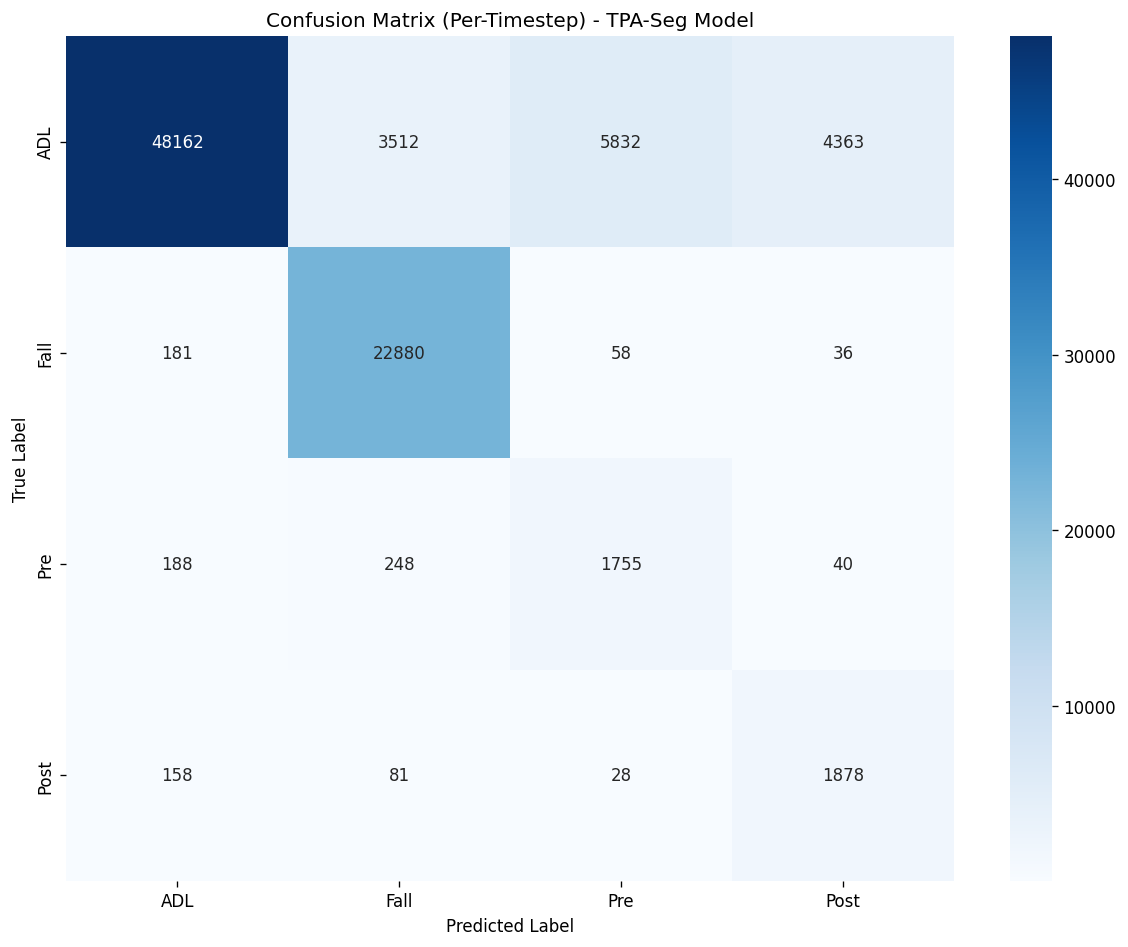

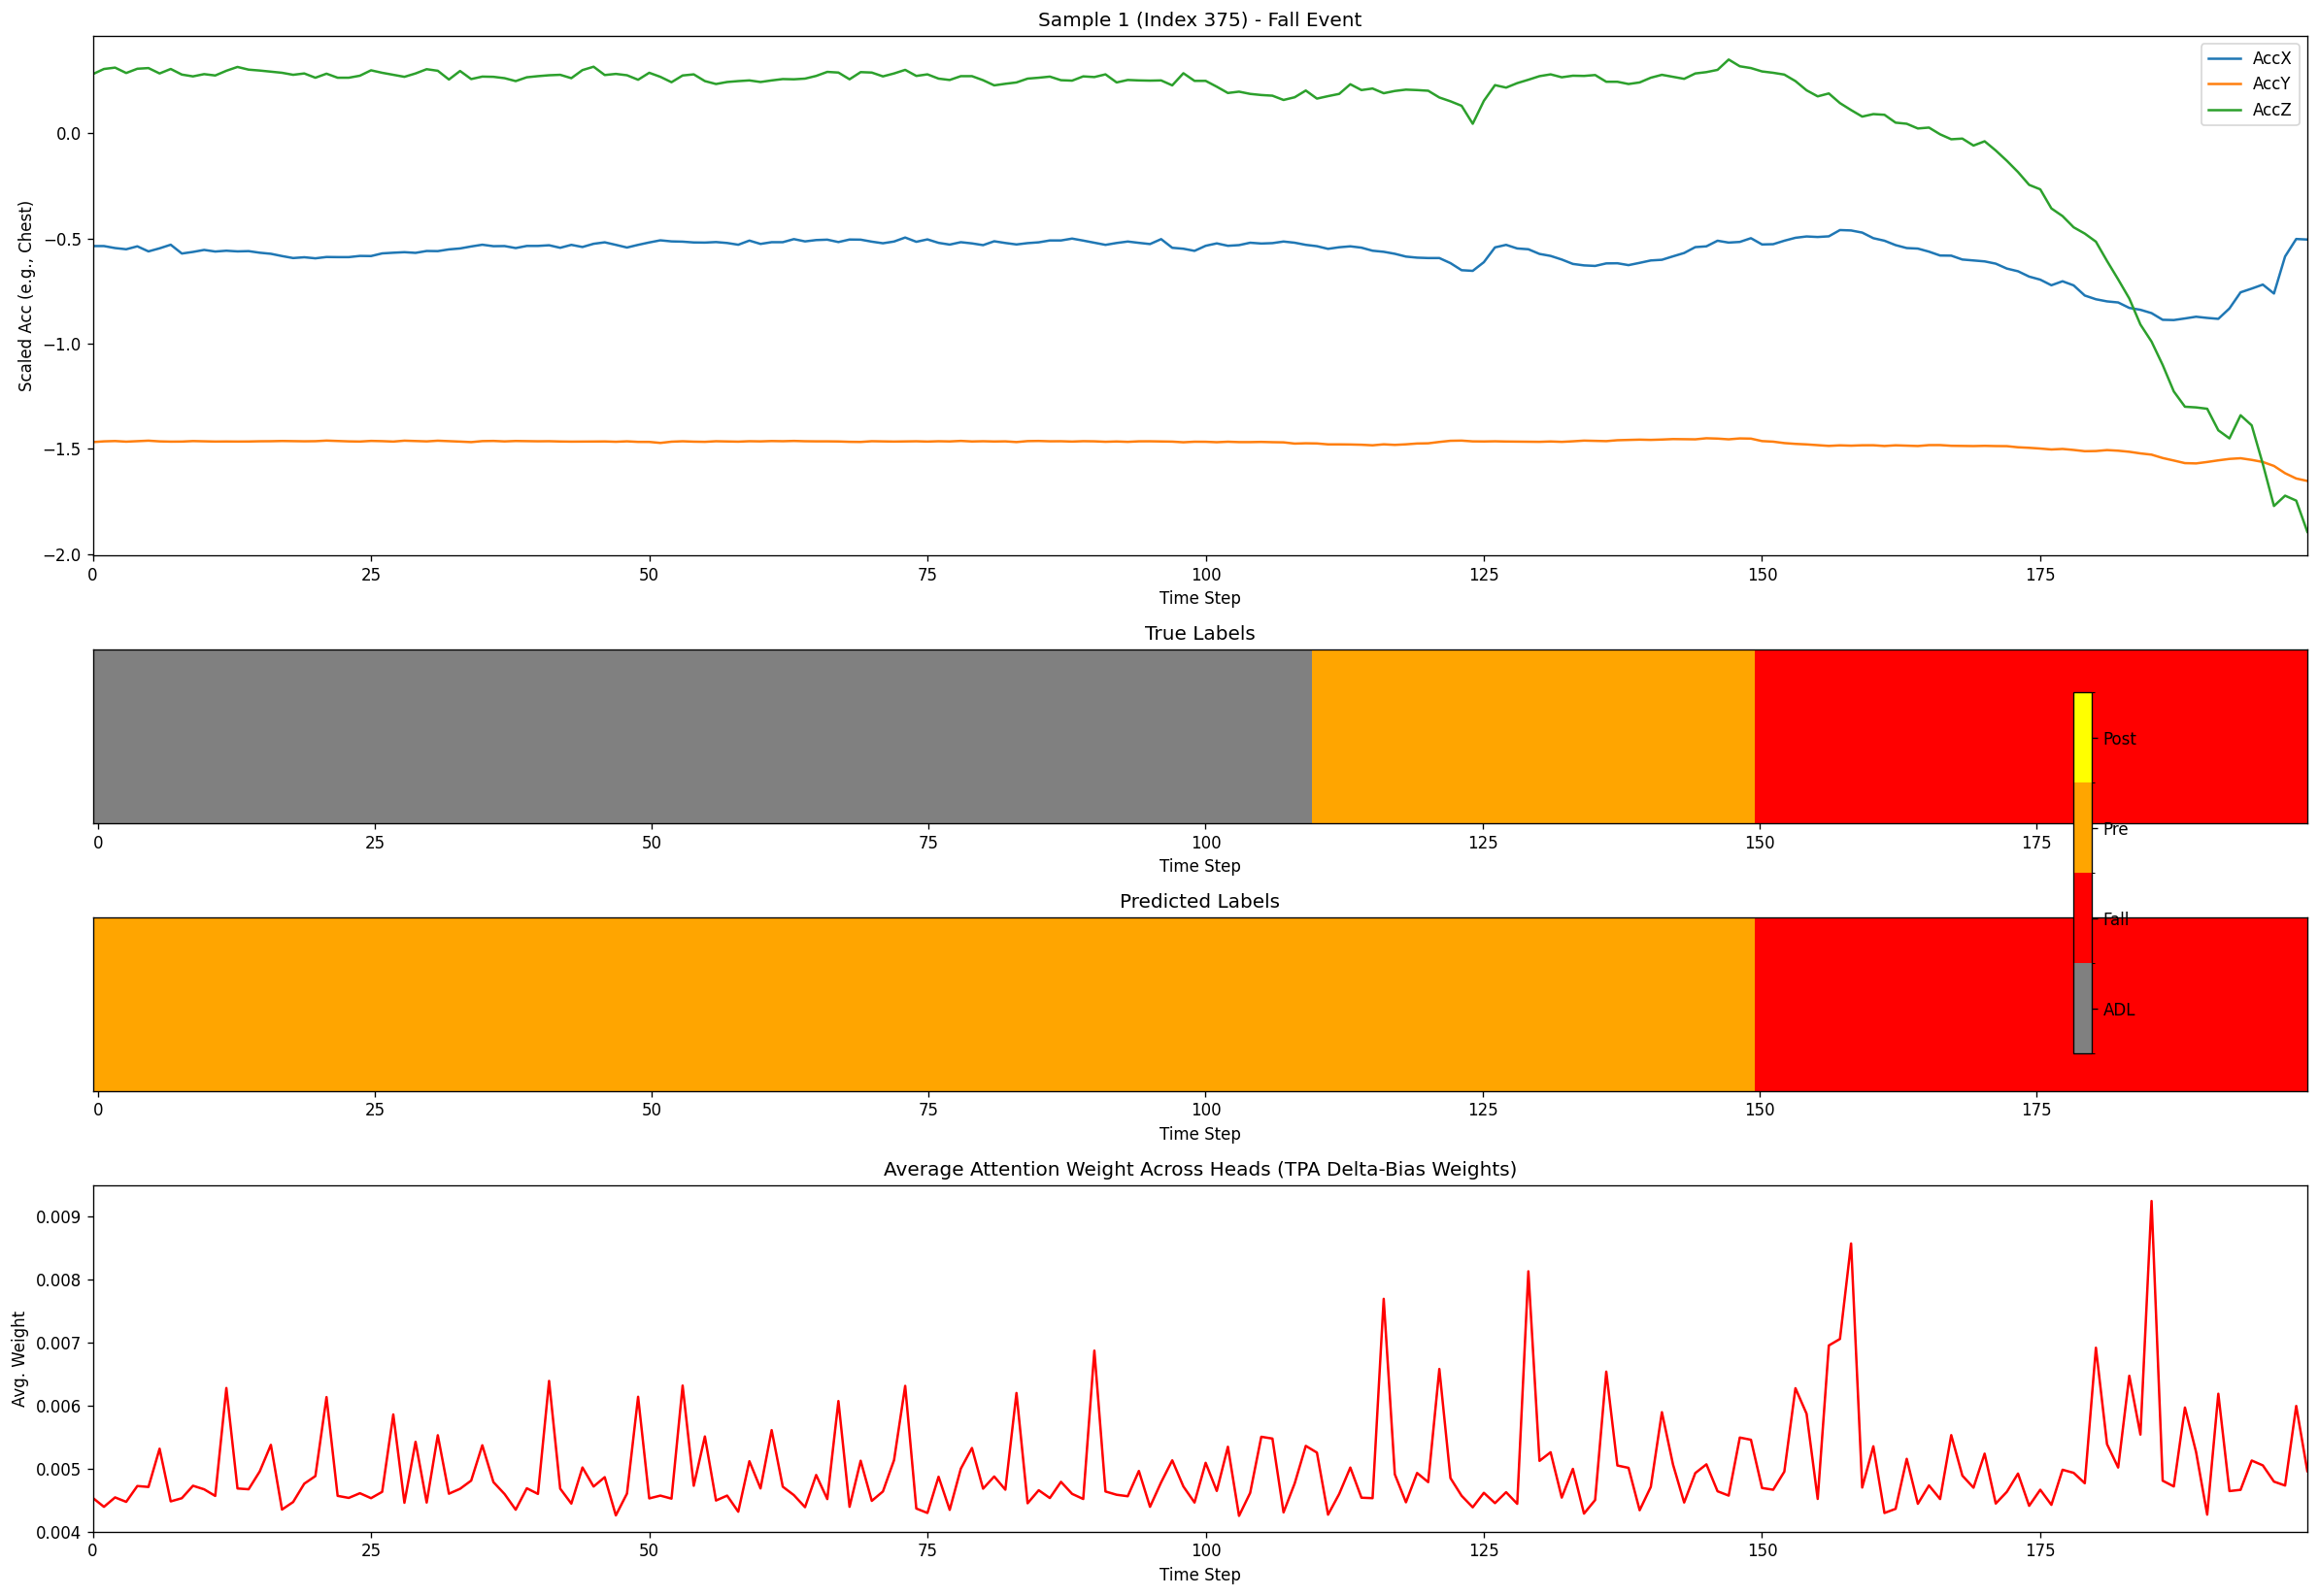

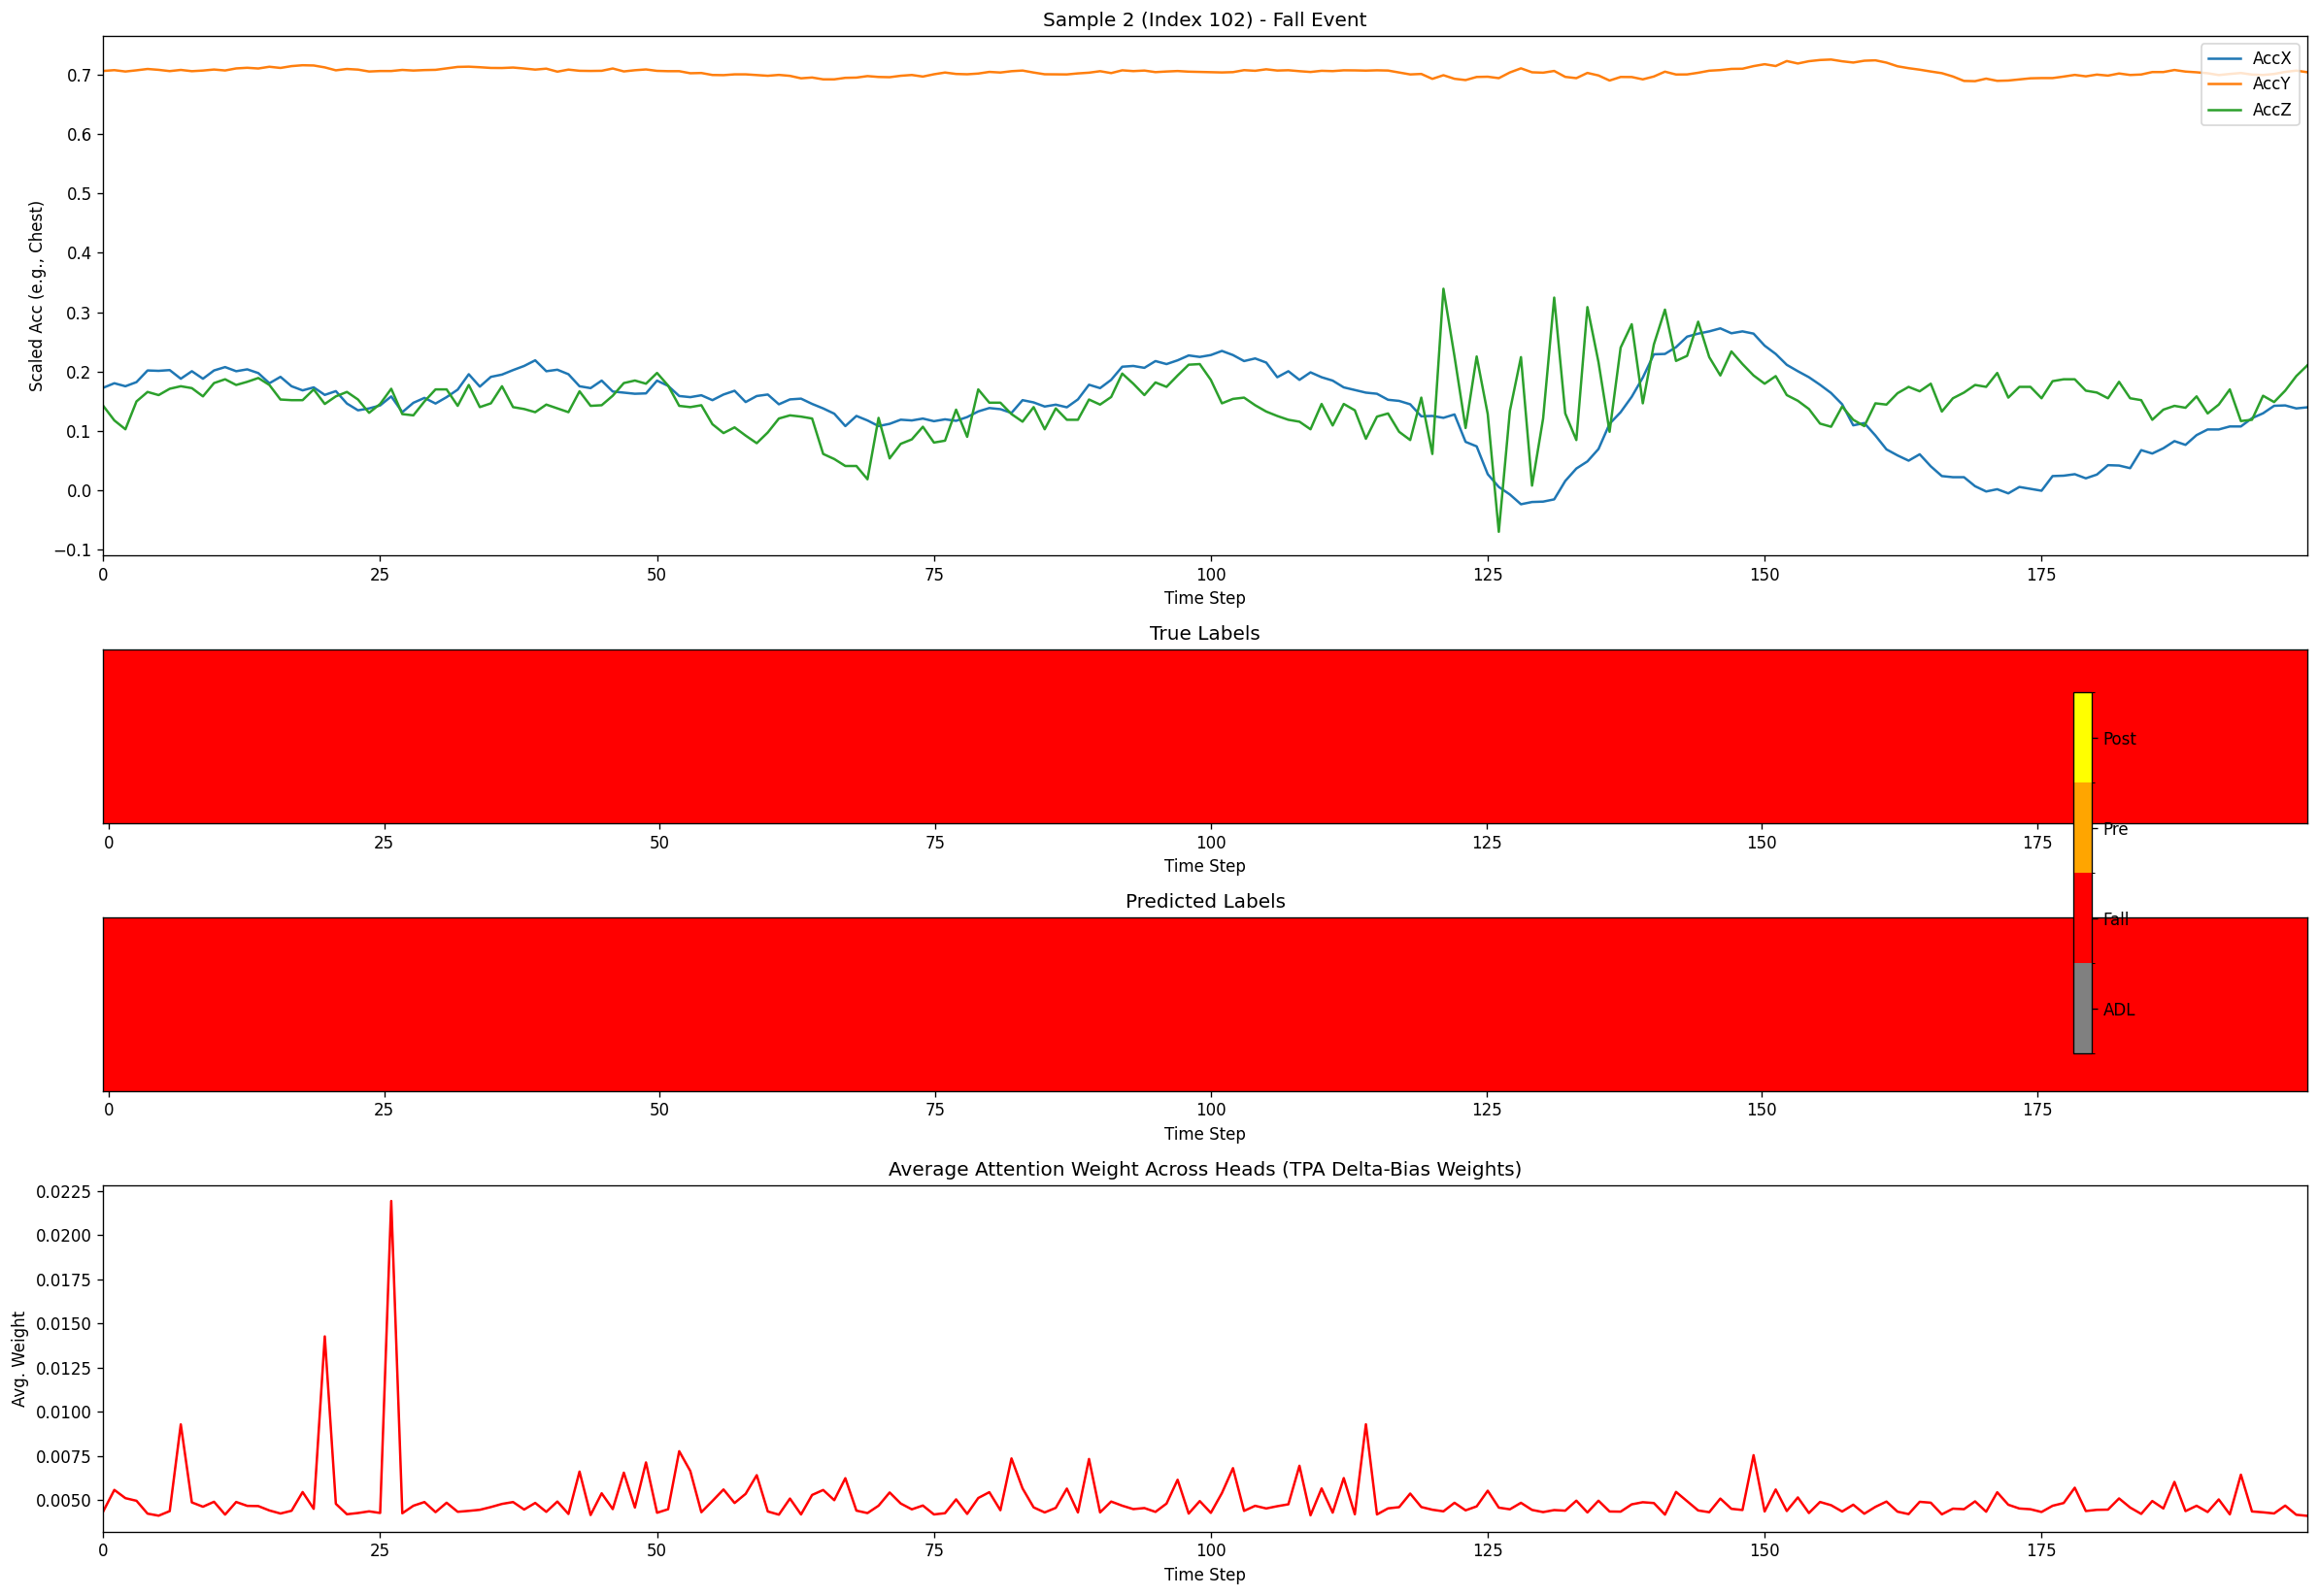

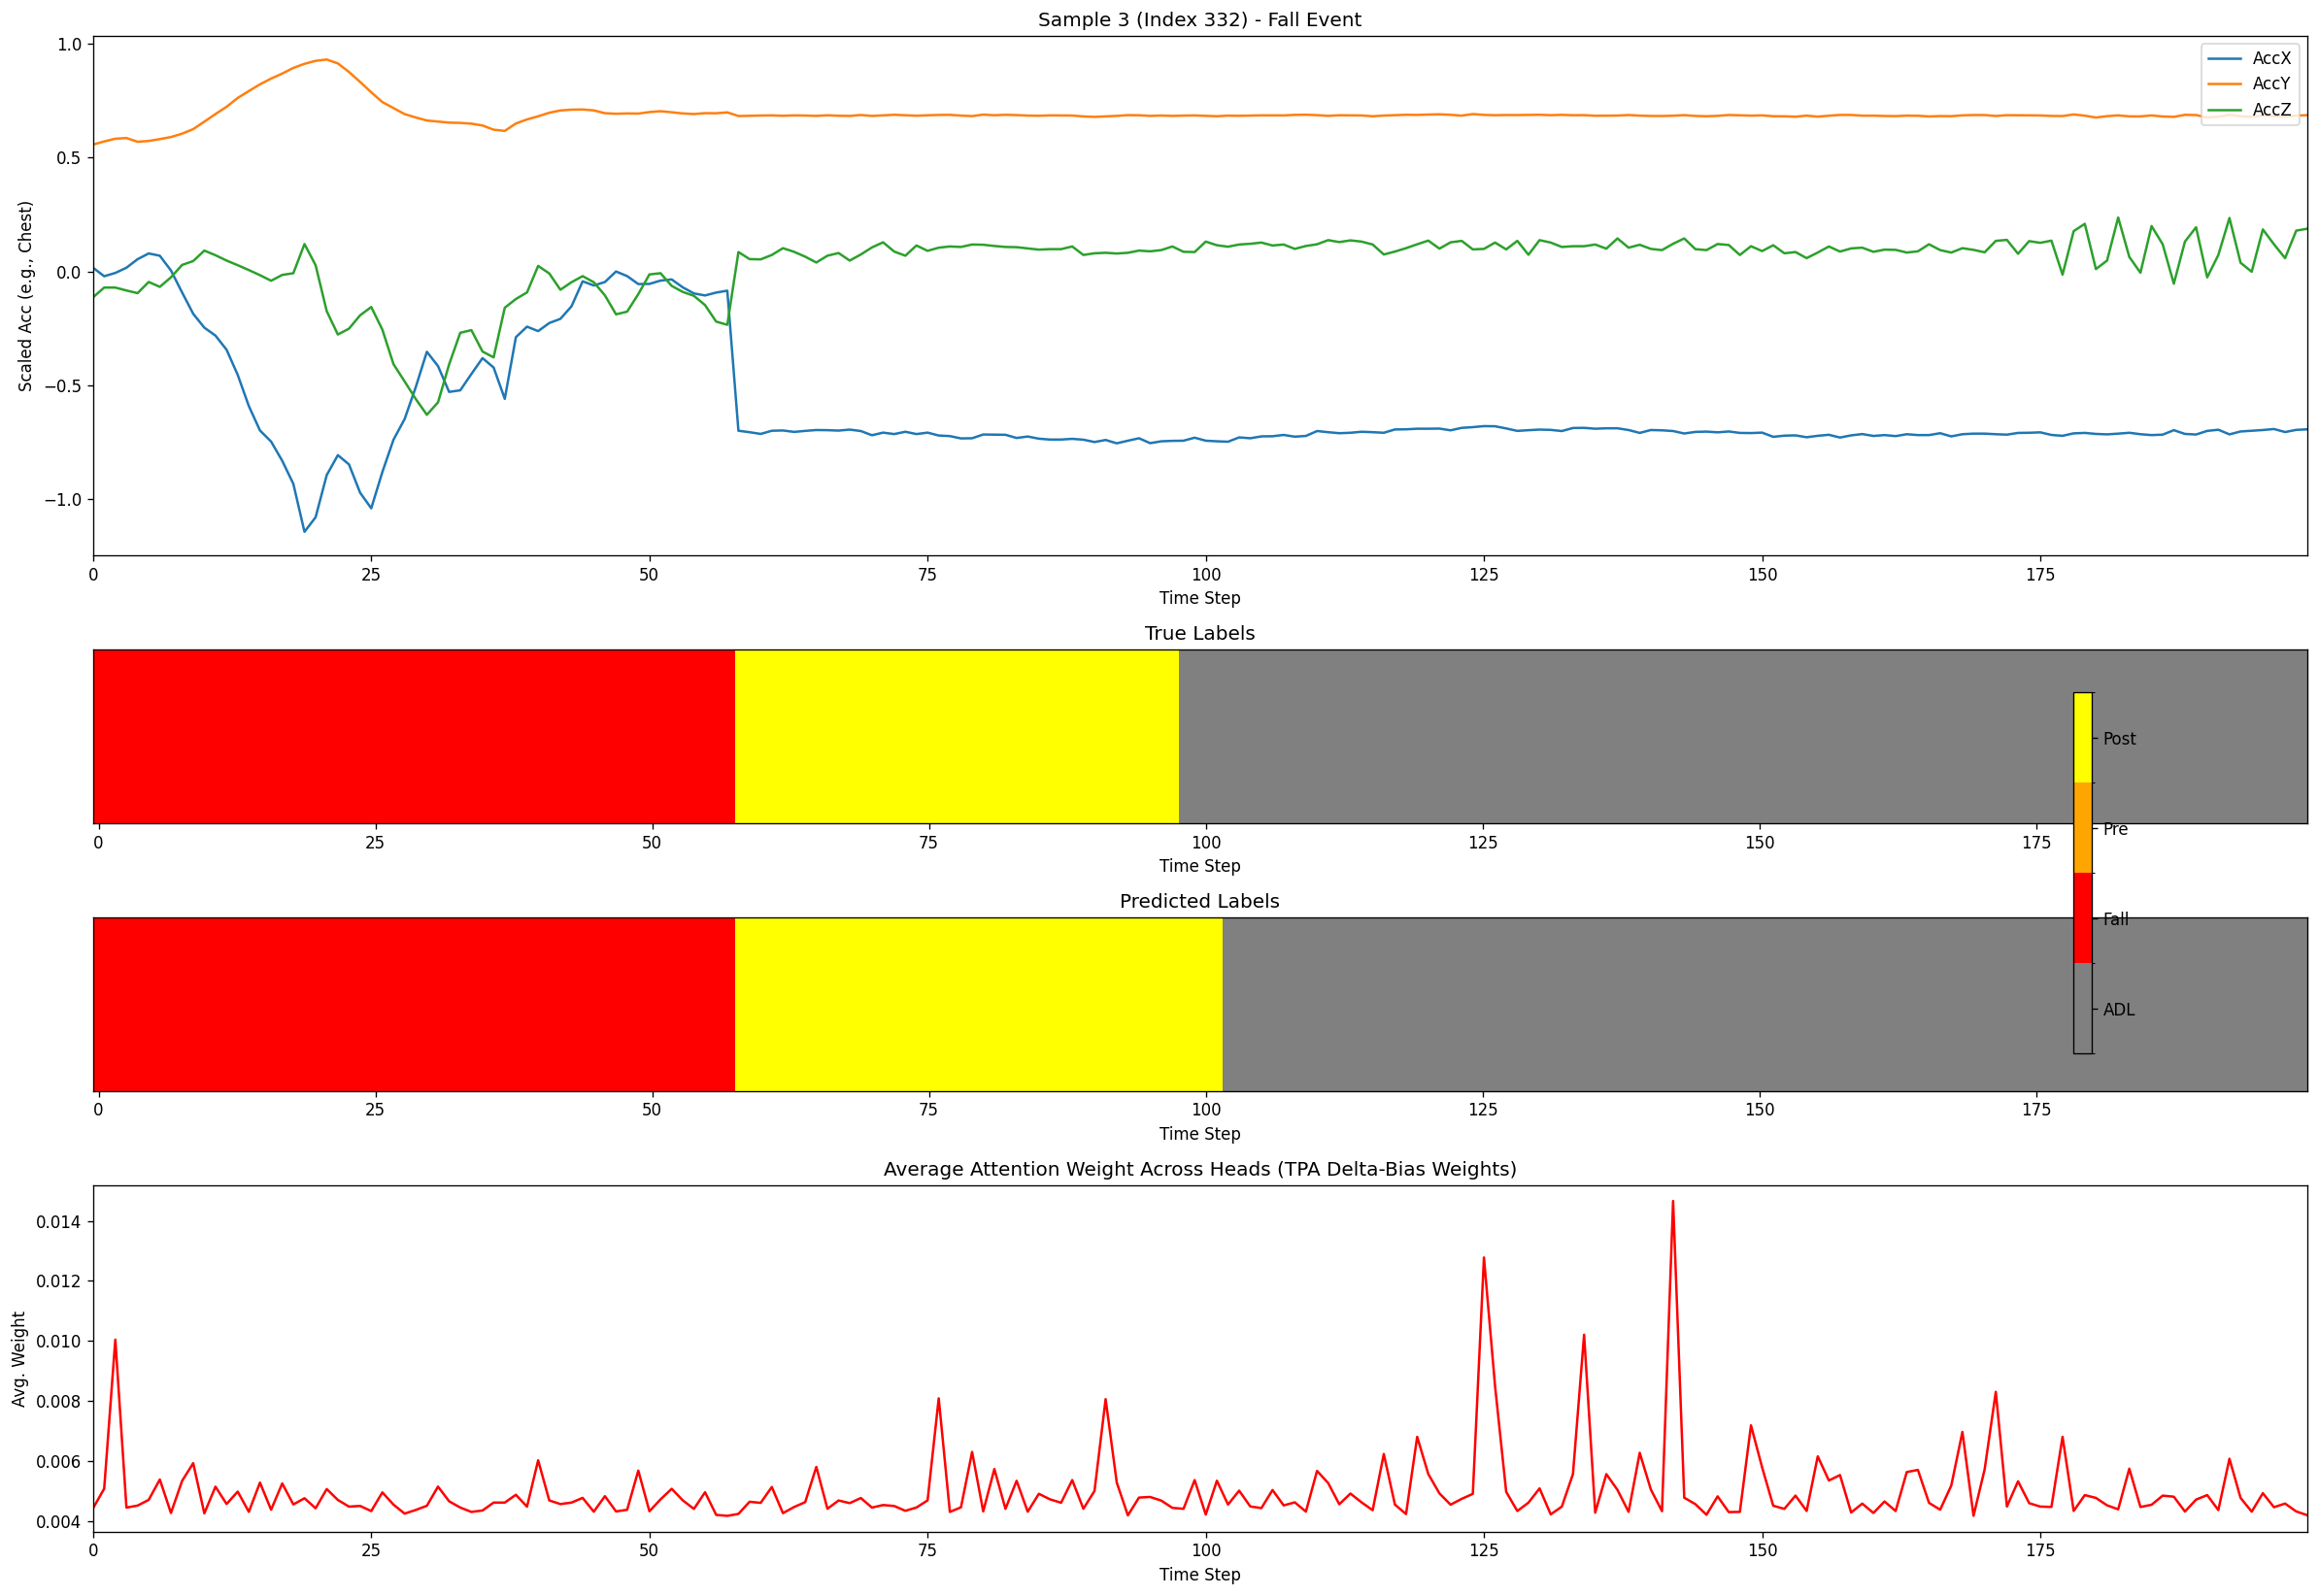

Segmentation plots saved to 'segmentation_plots/' directory.


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from thop import profile
import re
import time


class FallDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class UMAFallLoader:
    def __init__(self, data_path, segment_len=200, stride=50, sr=20, pre_sec=2.0, post_sec=2.0):
        self.data_path = data_path
        self.segment_len = segment_len
        self.stride = stride
        self.sr = sr
        self.pre_len = int(sr * pre_sec)
        self.post_len = int(sr * post_sec)

    def parse_filename(self, filename):
        pattern = r'UMAFall_Subject_(\d+)_(ADL|Fall)_([a-zA-Z_]+)_(\d+)_(\d{4}-\d{2}-\d{2})_.*\.csv'
        match = re.match(pattern, filename)

        if match:
            subject_id = int(match.group(1))
            activity_type = match.group(2)
            activity = match.group(3)
            trial = int(match.group(4))
            date = match.group(5)
            return subject_id, activity_type, activity, trial, date
        return None

    def read_all_sensors_file(self, filepath):
        print (filepath)
        sensor_data = {
            'RIGHTPOCKET': {'id': None, 'data': []},
            'CHEST': {'id': None, 'data': []},
            'WRIST': {'id': None, 'data': []},
            'WAIST': {'id': None, 'data': []},
            'ANKLE': {'id': None, 'data': []}
        }

        with open(filepath, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if ';' in line and any(pos in line for pos in sensor_data.keys()):
                    parts = line.strip().split(';')
                    if len(parts) >= 3:
                        sensor_id = parts[1].strip()
                        position = parts[2].strip()
                        if position in sensor_data:
                            sensor_data[position]['id'] = sensor_id

            data_start = False
            for line in lines:
                if '% TimeStamp; Sample No;' in line:
                    data_start = True
                    continue

                if data_start:
                    try:
                        values = [float(v.strip()) for v in line.split(';')]
                        sensor_id = str(int(values[-1]))
                        sensor_type = int(values[-2])
                        data = values[2:5]

                        for position, info in sensor_data.items():
                            if info['id'] == sensor_id:
                                info['data'].append([*data, sensor_type])
                    except:
                        continue

        for position in sensor_data:
            if sensor_data[position]['data']:
                sensor_data[position]['data'] = np.array(sensor_data[position]['data'])
            else:
                sensor_data[position]['data'] = None

        return sensor_data

    def process_sensor_data(self, sensor_data):
        processed_data = {}
        valid_lengths = []

        for position, data in sensor_data.items():
            if data['data'] is not None:
                acc_mask = data['data'][:, -1] == 0
                gyro_mask = data['data'][:, -1] == 1
                mag_mask = data['data'][:, -1] == 2

                acc_data = data['data'][acc_mask][:, :3] if np.any(acc_mask) else np.array([])
                gyro_data = data['data'][gyro_mask][:, :3] if np.any(gyro_mask) else np.array([])
                mag_data = data['data'][mag_mask][:, :3] if np.any(mag_mask) else np.array([])

                if len(acc_data) > 0:
                    valid_lengths.append(len(acc_data))
                if len(gyro_data) > 0:
                    valid_lengths.append(len(gyro_data))
                if len(mag_data) > 0:
                    valid_lengths.append(len(mag_data))

        if not valid_lengths:
            return None

        min_length = min(valid_lengths)

        for position, data in sensor_data.items():
            if data['data'] is not None:
                acc_mask = data['data'][:, -1] == 0
                gyro_mask = data['data'][:, -1] == 1
                mag_mask = data['data'][:, -1] == 2

                if np.any(acc_mask):
                    acc_data = data['data'][acc_mask][:min_length, :3]
                    acc_cols = [f'{position.lower()}_acc_x', f'{position.lower()}_acc_y', f'{position.lower()}_acc_z']
                    processed_data.update(dict(zip(acc_cols, acc_data.T)))

                if np.any(gyro_mask):
                    gyro_data = data['data'][gyro_mask][:min_length, :3]
                    gyro_cols = [f'{position.lower()}_gyro_x', f'{position.lower()}_gyro_y', f'{position.lower()}_gyro_z']
                    processed_data.update(dict(zip(gyro_cols, gyro_data.T)))

                if np.any(mag_mask):
                    mag_data = data['data'][mag_mask][:min_length, :3]
                    mag_cols = [f'{position.lower()}_mag_x', f'{position.lower()}_mag_y', f'{position.lower()}_mag_z']
                    processed_data.update(dict(zip(mag_cols, mag_data.T)))

        if not processed_data:
            return None

        return pd.DataFrame(processed_data)

    def generate_pre_post_labels(self, raw_labels):
        labels = raw_labels.copy()
        n = len(labels)

        for i in range(n):
            if i < n - 1 and labels[i] == 1 and labels[i + 1] != 1:
                end_idx = min(i + 1 + self.post_len, n)
                labels[i+1:end_idx] = 3

        for i in range(n):
            if raw_labels[i] == 1 and (i == 0 or raw_labels[i-1] == 0):
                start_idx = max(0, i - self.pre_len)
                labels[start_idx:i] = 2

        return labels

    def sliding_window(self, data, labels):
        segments = []
        segment_labels = []

        for i in range(0, len(data) - self.segment_len + 1, self.stride):
            segment = data[i:i + self.segment_len]
            label_segment = labels[i:i + self.segment_len]

            segments.append(segment)
            segment_labels.append(label_segment)

        return np.array(segments), np.array(segment_labels)

    def prepare_dataset(self, split_ratios):
        all_files = glob.glob(os.path.join(self.data_path, "*.csv"))

        print("\n" + "="*80)
        print("Loading UMAFall Dataset (Segmentation Mode)")
        print("="*80)

        subject_data = {}

        for file in all_files:
            filename = os.path.basename(file)
            info = self.parse_filename(filename)

            if info:
                subject_id = info[0]
                sensor_data = self.read_all_sensors_file(file)
                df = self.process_sensor_data(sensor_data)

                if df is not None:
                    df['activity'] = info[2]

                    if subject_id not in subject_data:
                        subject_data[subject_id] = []
                    subject_data[subject_id].append(df)

        subjects = sorted(subject_data.keys())
        print(f"Total subjects found: {len(subjects)}")

        all_segments_raw = []
        all_segment_labels = []

        print("\n" + "="*80)
        print("Processing all subjects...")
        print("="*80)

        for subject in subjects:
            dfs = subject_data.get(subject, [])
            if not dfs: continue

            subject_df = pd.concat(dfs, ignore_index=True)
            subject_df['activity'] = subject_df['activity'].map(
                lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0
            )
            subject_df = subject_df.dropna()

            sensor_columns = [col for col in subject_df.columns if any(x in col for x in ['acc', 'gyro', 'mag'])]
            if not sensor_columns: continue

            sensor_data_raw = subject_df[sensor_columns].values
            labels = subject_df['activity'].values

            labels_4class = self.generate_pre_post_labels(labels)

            segments, segment_labels = self.sliding_window(sensor_data_raw, labels_4class)
            if segments.size == 0: continue

            all_segments_raw.append(segments)
            all_segment_labels.append(segment_labels)

            print(f"Subject {subject}: {len(segments)} segments generated.")

        X_all_raw = np.concatenate(all_segments_raw, axis=0)
        y_all = np.concatenate(all_segment_labels, axis=0)

        print("\n" + "="*80)
        print(f"Total segments generated (pre-split): {len(X_all_raw)}")

        stratify_key = [1 if 1 in y_seg else 0 for y_seg in y_all]

        indices = np.arange(len(y_all))

        train_val_indices, test_indices = train_test_split(
            indices,
            test_size=split_ratios[2],
            random_state=42,
            stratify=stratify_key
        )

        val_size_ratio = split_ratios[1] / (split_ratios[0] + split_ratios[1])

        train_indices, val_indices = train_test_split(
            train_val_indices,
            test_size=val_size_ratio,
            random_state=42,
            stratify=np.array(stratify_key)[train_val_indices]
        )

        X_train_raw = X_all_raw[train_indices]
        y_train = y_all[train_indices]

        X_val_raw = X_all_raw[val_indices]
        y_val = y_all[val_indices]

        X_test_raw = X_all_raw[test_indices]
        y_test = y_all[test_indices]

        print("\n" + "="*80)
        print("Scaling data...")
        print("="*80)

        scaler = StandardScaler()

        n_features = X_train_raw.shape[2]
        X_train_2d = X_train_raw.reshape(-1, n_features)
        scaler.fit(X_train_2d)

        train_X = scaler.transform(X_train_2d).reshape(X_train_raw.shape)
        val_X = scaler.transform(X_val_raw.reshape(-1, n_features)).reshape(X_val_raw.shape)
        test_X = scaler.transform(X_test_raw.reshape(-1, n_features)).reshape(X_test_raw.shape)

        print(" ✓ Scaler fitted on train data and applied to all splits.")

        print("\n" + "="*80)
        print("Final Dataset Statistics")
        print("="*80)
        print(f"Train: {train_X.shape}, {y_train.shape}")
        print(f"Val:   {val_X.shape}, {y_val.shape}")
        print(f"Test:  {test_X.shape}, {y_test.shape}")

        return train_X, y_train, val_X, y_val, test_X, y_test


class FormalTPA(nn.Module):
    def __init__(self, dim, heads=4, tau=1.0, bias_scale=1.0):
        super().__init__()
        assert dim % heads == 0
        self.dim = dim
        self.heads = heads
        self.dim_head = dim // heads
        self.scale = self.dim_head ** -0.5
        self.tau = tau
        self.bias_scale = bias_scale

        self.q_proj = nn.Linear(dim, dim)
        self.k_proj = nn.Linear(dim, dim)
        self.v_proj = nn.Linear(dim, dim)
        self.out_proj = nn.Linear(dim, dim)

        self.delta_norm = nn.LayerNorm(dim)
        self.delta_act = nn.GELU()
        self.delta_net = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, dim),
            nn.GELU(),
            nn.Linear(dim, heads * 2)
        )
        self.res_norm = nn.LayerNorm(dim)

    def forward(self, x):
        B, T, D = x.shape
        H, Dh = self.heads, self.dim_head

        delta = torch.zeros_like(x)
        delta[:, 1:, :] = x[:, 1:, :] - x[:, :-1, :]
        delta = self.delta_norm(delta)

        gate_scores = self.delta_net(delta)
        logit_bias_scores, value_gate_logits = torch.chunk(gate_scores, 2, dim=-1)

        logit_bias_weights = F.softmax(logit_bias_scores.transpose(1, 2) / self.tau, dim=-1)
        logit_bias = self.bias_scale * logit_bias_weights.unsqueeze(2)

        value_gate = torch.sigmoid(value_gate_logits).permute(0, 2, 1).unsqueeze(-1)

        q = self.q_proj(x).view(B, T, H, Dh).permute(0, 2, 1, 3)
        k = self.k_proj(x).view(B, T, H, Dh).permute(0, 2, 1, 3)
        v = self.v_proj(x).view(B, T, H, Dh).permute(0, 2, 1, 3)

        v_gated = v * value_gate

        logits = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        logits = logits + logit_bias
        attn = F.softmax(logits, dim=-1)

        out = torch.matmul(attn, v_gated)
        out = out.permute(0, 2, 1, 3).reshape(B, T, D)
        out = self.out_proj(out)
        out = self.res_norm(x + out)

        return out, logit_bias_weights


class TPASegModel(nn.Module):
    def __init__(self, in_ch, dim, num_classes, heads, tau, bias_scale):
        super().__init__()
        self.dim = dim
        self.input_proj = nn.Linear(in_ch, dim)

        self.cnn_block = nn.Sequential(
            nn.Conv1d(in_channels=dim, out_channels=dim,
                      kernel_size=5, padding='same'),
            nn.GELU(),
            nn.BatchNorm1d(dim),
            nn.Dropout(0.3)
        )

        self.tpa = FormalTPA(dim, heads, tau, bias_scale)

        self.out_proj = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        B, T, _ = x.shape

        x = self.input_proj(x)

        x_cnn = x.permute(0, 2, 1)
        x_cnn = self.cnn_block(x_cnn)
        x_cnn = x_cnn.permute(0, 2, 1)

        x_res = x + x_cnn

        x_tpa, attn_map = self.tpa(x_res)

        out = self.out_proj(x_tpa)

        return out, attn_map


def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X, y in loader:
        X, y = X.to(device), y.to(device)
        B, T = y.shape

        optimizer.zero_grad()
        outputs, _ = model(X)

        outputs_flat = outputs.view(-1, 4)
        y_flat = y.view(-1)

        loss = criterion(outputs_flat, y_flat)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * B

        _, predicted = outputs_flat.max(1)
        total += y_flat.size(0)
        correct += predicted.eq(y_flat).sum().item()

    return total_loss / len(loader.dataset), 100. * correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_preds_flat = []
    all_labels_flat = []

    all_preds_seg = []
    all_labels_seg = []
    all_attn_maps = []
    all_X_data = []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            B, T = y.shape

            outputs, attn_maps = model(X)

            outputs_flat = outputs.view(-1, 4)
            y_flat = y.view(-1)

            loss = criterion(outputs_flat, y_flat)
            total_loss += loss.item() * B

            _, predicted_flat = outputs_flat.max(1)
            total += y_flat.size(0)
            correct += predicted_flat.eq(y_flat).sum().item()

            all_preds_flat.extend(predicted_flat.cpu().numpy())
            all_labels_flat.extend(y_flat.cpu().numpy())

            predicted_seg = predicted_flat.view(B, T)
            all_preds_seg.append(predicted_seg.cpu().numpy())
            all_labels_seg.append(y.cpu().numpy())
            all_attn_maps.append(attn_maps.cpu().numpy())
            all_X_data.append(X.cpu().numpy())

    all_preds_seg_np = np.concatenate(all_preds_seg, axis=0)
    all_labels_seg_np = np.concatenate(all_labels_seg, axis=0)
    all_attn_maps_np = np.concatenate(all_attn_maps, axis=0)
    all_X_data_np = np.concatenate(all_X_data, axis=0)

    return total_loss / len(loader.dataset), 100. * correct / total, \
           all_preds_flat, all_labels_flat, \
           all_X_data_np, all_labels_seg_np, all_preds_seg_np, all_attn_maps_np


def plot_segmentation_results(X_data, y_true, y_pred, attn_maps, num_samples=3):
    labels_map = {0: 'ADL', 1: 'Fall', 2: 'Pre', 3: 'Post'}
    colors = ['gray', 'red', 'orange', 'yellow']
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(np.arange(-0.5, 4), cmap.N)

    if not os.path.exists('segmentation_plots'):
        os.makedirs('segmentation_plots')

    fall_indices = np.where([1 in y for y in y_true])[0]

    if len(fall_indices) == 0:
        print("No fall samples found in test set for plotting.")
        return

    selected_indices = np.random.choice(fall_indices, min(num_samples, len(fall_indices)), replace=False)

    print("\n" + "="*80)
    print("Generating Segmentation Plots...")
    print("="*80)

    for i, idx in enumerate(selected_indices):
        signal = X_data[idx]
        true_labels = y_true[idx].reshape(1, -1)
        pred_labels = y_pred[idx].reshape(1, -1)
        attn_avg = np.mean(attn_maps[idx], axis=0)

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 15),
                                             gridspec_kw={'height_ratios': [3, 1, 1, 2]})

        ax1.plot(signal[:, 0:3], label=['AccX', 'AccY', 'AccZ'])
        ax1.set_ylabel('Scaled Acc (e.g., Chest)')
        ax1.legend(loc='upper right')
        ax1.set_title(f"Sample {i+1} (Index {idx}) - Fall Event")
        ax1.set_xlabel('Time Step')
        ax1.set_xlim(0, len(signal)-1)

        ax2.imshow(true_labels, cmap=cmap, norm=norm, aspect='auto')
        ax2.set_title('True Labels')
        ax2.set_yticks([])
        ax2.set_xlabel('Time Step')

        ax3.imshow(pred_labels, cmap=cmap, norm=norm, aspect='auto')
        ax3.set_title('Predicted Labels')
        ax3.set_yticks([])
        ax3.set_xlabel('Time Step')

        cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm),
                            ax=[ax2, ax3], orientation='vertical',
                            ticks=[0, 1, 2, 3], fraction=0.01, pad=0.01)
        cbar.ax.set_yticklabels(labels_map.values())

        ax4.plot(attn_avg, color='r')
        ax4.set_title('Average Attention Weight Across Heads (TPA Delta-Bias Weights)')
        ax4.set_xlabel('Time Step')
        ax4.set_ylabel('Avg. Weight')
        ax4.set_xlim(0, len(attn_avg)-1)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(f'segmentation_plots/segmentation_sample_{i+1}.png', dpi=150)
        plt.show()
        plt.close(fig)

    print(f"Segmentation plots saved to 'segmentation_plots/' directory.")


def main():
    CONFIG = {
        'segment_len': 200,
        'stride': 50,
        'batch_size': 128,
        'epochs': 100,
        'hidden_dim': 256,
        'umafall_path': "/content/drive/MyDrive/HAR_Dataset/UMAFALL",
        'tpa_heads': 8,
        'tpa_tau': 1.0,
        'tpa_bias_scale': 1.0,
        'class_weights': [0.1, 8.0, 5.0, 5.0],
        'sr': 20,
        'pre_sec': 2.0,
        'post_sec': 2.0,
        'split_ratios': [0.7, 0.15, 0.15]
    }

    np.random.seed(42)
    torch.manual_seed(42)

    loader = UMAFallLoader(CONFIG['umafall_path'],
                           segment_len=CONFIG['segment_len'],
                           stride=CONFIG['stride'],
                           sr=CONFIG['sr'],
                           pre_sec=CONFIG['pre_sec'],
                           post_sec=CONFIG['post_sec'])

    train_X, train_y, val_X, val_y, test_X, test_y = loader.prepare_dataset(
        split_ratios=CONFIG['split_ratios']
    )

    train_ds = FallDataset(train_X, train_y)
    val_ds = FallDataset(val_X, val_y)
    test_ds = FallDataset(test_X, test_y)

    train_loader = DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False)

    print("\n" + "="*80)
    print("Build Model (TPA-Segmentation)")
    print("="*80)

    if len(train_X) == 0:
        print("Error: No training data loaded. Exiting.")
        return

    in_channels = train_X.shape[2]
    print(f"Input channels: {in_channels}")
    print(f"Segment length: {CONFIG['segment_len']}")

    model = TPASegModel(
        in_ch=in_channels,
        dim=CONFIG['hidden_dim'],
        num_classes=4,
        heads=CONFIG['tpa_heads'],
        tau=CONFIG['tpa_tau'],
        bias_scale=CONFIG['tpa_bias_scale']
    )

    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f" ✓ Parameters: {n_params:,}")
    print(f" ✓ Model: CNN(k=5) -> TPA(heads={CONFIG['tpa_heads']}) -> Per-Step Linear")

    weights = torch.FloatTensor(CONFIG['class_weights'])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    weights = weights.to(device)

    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    print("\n" + "="*80)
    print("Class Weights:")
    print("="*80)
    for name, w in zip(['ADL','Fall','Pre','Post'], CONFIG['class_weights']):
        print(f" {name:7s}: {w:.2f}")

    print("\n" + "="*80)
    print("Training Start")
    print("="*80)

    best_val_loss = float('inf')
    best_epoch = 0

    for epoch in range(CONFIG['epochs']):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _, _, _, _, _ = evaluate(model, val_loader, criterion, device)

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1:2d}/{CONFIG['epochs']} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            torch.save(model.state_dict(), 'best_model.pth')

    print("\n" + "="*80)
    print(f"Best Validation Loss: {best_val_loss:.4f} at Epoch {best_epoch}")
    print("="*80)

    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc, preds_flat, gts_flat, \
    X_test_plot, y_true_plot, y_pred_plot, attn_maps_plot = evaluate(model, test_loader, criterion, device)

    print("\n" + "="*80)
    print("Test Set Performance (Per-Timestep)")
    print("="*80)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")

    print("\n" + classification_report(gts_flat, preds_flat, labels=[0,1,2,3],
                                target_names=['ADL','Fall','Pre-fall','Post-fall'],
                                digits=4, zero_division=0))

    cm = confusion_matrix(gts_flat, preds_flat, labels=[0,1,2,3])
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['ADL','Fall','Pre','Post'],
                yticklabels=['ADL','Fall','Pre','Post'])
    plt.title('Confusion Matrix (Per-Timestep) - TPA-Seg Model')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_segmentation.png', dpi=300, bbox_inches='tight')
    print("\nConfusion matrix saved to 'confusion_matrix_segmentation.png'")

    dummy_input = torch.randn(1, CONFIG['segment_len'], in_channels).to(device)
    flops, params = profile(model, inputs=(dummy_input,), verbose=False)
    print(f"\nModel Statistics:")
    print(f"  Params (M):  {params / 1e6:.2f}")
    print(f"  FLOPs (M):   {flops / 1e6:.2f}")

    model.eval()
    times = []
    with torch.no_grad():
        for _ in range(100):
            start = time.time()
            _ = model(dummy_input)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            times.append((time.time() - start) * 1000)
    print(f"  Inference (ms): {np.mean(times[10:]):.2f}")

    plot_segmentation_results(X_test_plot, y_true_plot, y_pred_plot, attn_maps_plot, num_samples=3)


if __name__ == '__main__':
    main()